In [3]:
!pip install git+https://github.com/facebookresearch/sam2.git
import os
import sys
import cv2
import numpy as np
import torch
from tqdm import tqdm
from google.colab import drive
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
!pip install hydra-core iopath -q

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Configurar Caminhos
BASE_SAMSUNG = "/content/drive/MyDrive/SAMSUNG"
PATH_SAM2 = os.path.join(BASE_SAMSUNG, "sam2-main")

if PATH_SAM2 not in sys.path:
    sys.path.append(PATH_SAM2)

#  Novos caminhos de entrada
BASE_PBC = os.path.join(BASE_SAMSUNG, "PBC-YOLO-811/PBC-YOLO-811")
IMG_ROOT = os.path.join(BASE_PBC, "images")
LBL_ROOT = os.path.join(BASE_PBC, "labels")

OUT_BASE = os.path.join(BASE_SAMSUNG, "parametros")
OUT_IMG = os.path.join(OUT_BASE, "images")
OUT_MASK_SAM = os.path.join(OUT_BASE, "masks")
os.makedirs(OUT_IMG, exist_ok=True)
os.makedirs(OUT_MASK_SAM, exist_ok=True)


# 3. Carregar Modelo SAM2
os.chdir(PATH_SAM2)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Dispositivo: {device.upper()}")

predictor = SAM2ImagePredictor(build_sam2(
    "configs/sam2.1/sam2.1_hiera_l.yaml",
    "checkpoints/sam2.1_hiera_large.pt",
    device=device
))

predictor.model.mask_threshold = 0.0



def pad_image_for_border_cells(img, pad_size=50):
    return cv2.copyMakeBorder(img, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT_101)

def is_near_border(cx, cy, bw, bh, img_width, img_height, threshold=1.5):
    margin_x, margin_y = bw * threshold, bh * threshold
    return (cx < margin_x or cx > img_width - margin_x or cy < margin_y or cy > img_height - margin_y)

def choose_best_mask(masks, scores, bbox, point_coords, img_shape):
    if len(masks) == 0: return 0
    x1, y1, x2, y2 = bbox
    expected_area = max((x2 - x1) * (y2 - y1), 1)
    best_score, best_idx = -1, 0
    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask_area = mask.sum()
        if mask_area == 0: continue
        area_ratio = min(mask_area, expected_area) / max(mask_area, expected_area)
        cy, cx = int(point_coords[0][1]), int(point_coords[0][0]) # Ajustar de índice
        contains_center = mask[cy, cx] if 0 <= cy < mask.shape[0] and 0 <= cx < mask.shape[1] else False
        rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
        aspect_ratio = (min(rows.sum(), cols.sum()) / max(rows.sum(), cols.sum())) if rows.any() else 0
        combined_score = (score * 0.45 + area_ratio * 0.25 + (0.20 if contains_center else 0) + aspect_ratio * 0.10)
        if combined_score > best_score:
            best_score, best_idx = combined_score, i
    return best_idx

def refine_mask(mask, class_id, min_area=10):
    class_mask = (mask == class_id).astype(np.uint8)
    if class_mask.sum() == 0: return mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(class_mask, connectivity=8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_area: class_mask[labels == i] = 0
    mask[mask == class_id] = 0
    mask[class_mask > 0] = class_id
    return mask

def parse_yolo_label_advanced(txt_path, img_width, img_height, pad_size=0):
    cells = []
    if not os.path.exists(txt_path): return cells
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.split()
            if len(parts) >= 5:
                cls = int(parts[0]) + 1
                cx, cy, bw, bh = float(parts[1])*img_width, float(parts[2])*img_height, float(parts[3])*img_width, float(parts[4])*img_height
                near_border = is_near_border(cx, cy, bw, bh, img_width, img_height)
                pad_factor = 0.20 if near_border else 0.10
                x1_adj, y1_adj = int(cx - (bw/2)*(1+pad_factor)) + pad_size, int(cy - (bh/2)*(1+pad_factor)) + pad_size
                x2_adj, y2_adj = int(cx + (bw/2)*(1+pad_factor)) + pad_size, int(cy + (bh/2)*(1+pad_factor)) + pad_size
                coords, labels = [[int(cx + pad_size), int(cy + pad_size)]], [1]
                cells.append({'class': cls, 'bbox': np.array([x1_adj, y1_adj, x2_adj, y2_adj]), 'coords': np.array(coords), 'labels': np.array(labels), 'near_border': near_border, 'center': (int(cx + pad_size), int(cy + pad_size))})
    return cells

def create_sam2_mask_optimized(img, txt_path, pad_size=50):
    h, w = img.shape[:2]
    img_padded = pad_image_for_border_cells(img, pad_size=pad_size)
    cells = parse_yolo_label_advanced(txt_path, w, h, pad_size=pad_size)
    if not cells: return np.zeros((h, w), dtype=np.uint8)
    mask_padded = np.zeros((h + 2*pad_size, w + 2*pad_size), dtype=np.uint8)
    predictor.set_image(cv2.cvtColor(img_padded, cv2.COLOR_BGR2RGB))
    for cell in cells:
        try:
            masks, scores, _ = predictor.predict(point_coords=cell['coords'], point_labels=cell['labels'], box=cell['bbox'], multimask_output=True)
            best_idx = choose_best_mask(masks, scores, cell['bbox'], cell['coords'], mask_padded.shape)
            mask_padded[masks[best_idx].astype(bool) & (mask_padded == 0)] = cell['class']
        except Exception: continue
    mask_final = mask_padded[pad_size:pad_size+h, pad_size:pad_size+w]
    for cls in np.unique(mask_final):
        if cls != 0: mask_final = refine_mask(mask_final, cls)
    return mask_final

# Processamento principal

TARGET_SIZE = (256, 256)
PAD_SIZE = 50

print(f"\n Iniciar processamento do dataset {BASE_PBC}")

for split in ['train', 'val', 'test']:
    img_split_path = os.path.join(IMG_ROOT, split)
    lbl_split_path = os.path.join(LBL_ROOT, split)

    if not os.path.exists(img_split_path):
        print(f" Split '{split}' não encontrado.")
        continue

    files = [f for f in os.listdir(img_split_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    print(f"\n Processar {split.upper()} ({len(files)} imagens)")

    for f in tqdm(files):
        img_path = os.path.join(img_split_path, f)
        txt_path = os.path.join(lbl_split_path, os.path.splitext(f)[0] + ".txt")

        img = cv2.imread(img_path)
        if img is None: continue

        mask = create_sam2_mask_optimized(img, txt_path, pad_size=PAD_SIZE)

        img_res = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        mask_res = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

        save_name = f"{split}_{f}"
        cv2.imwrite(os.path.join(OUT_IMG, save_name), img_res)

        mask_filename = os.path.splitext(save_name)[0] + ".png"
        cv2.imwrite(os.path.join(OUT_MASK_SAM, mask_filename), mask_res)

print(f"\n Concluído! O dataset pronto está em: {OUT_BASE}")

  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-h_vo8ls_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-h_vo8ls_
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.2 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=505250 sha256=f2d3fb1337661862227773239e3fc8d6b5f3029008fdfb97e149480b6ce8c63e
  Stored in directory: /tmp/pip-ephem-wheel-cache-wg7gvgd9/wheels/25/a3/8a/abd69dc6a6926b5e75c24810afac36c7b49b5c0f8a100147d6
  Created wheel for iopath: filename=iopath-0.1.10-py3-no

In [4]:
import os
import sys
import cv2
import numpy as np
import torch
from tqdm import tqdm
from google.colab import drive

# Montar o Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Definição das Bases
BASE_SAMSUNG = "/content/drive/MyDrive/SAMSUNG"
PATH_SAM2 = os.path.join(BASE_SAMSUNG, "sam2-main")

# Adicionar SAM2 ao Path do Sistema
if PATH_SAM2 not in sys.path:
    sys.path.append(PATH_SAM2)

# CAMINHOS DE ENTRADA 
BASE_PBC = os.path.join(BASE_SAMSUNG, "PBC-YOLO-811")
IMG_ROOT = os.path.join(BASE_PBC, "images")
LBL_ROOT = os.path.join(BASE_PBC, "labels")

#  CAMINHOS DE SAÍDA
OUT_BASE = os.path.join(BASE_SAMSUNG, "parametros")
OUT_IMG = os.path.join(OUT_BASE, "images")
OUT_MASK_SAM = os.path.join(OUT_BASE, "masks")


os.makedirs(OUT_IMG, exist_ok=True)
os.makedirs(OUT_MASK_SAM, exist_ok=True)

print(f" Diretórios configurados:")
print(f" Entrada: {BASE_PBC}")
print(f" Saída:   {OUT_BASE}")



os.chdir(PATH_SAM2)
device = "cuda" if torch.cuda.is_available() else "cpu"

predictor = SAM2ImagePredictor(build_sam2(
    "configs/sam2.1/sam2.1_hiera_l.yaml",
    "checkpoints/sam2.1_hiera_large.pt",
    device=device
))

predictor.model.mask_threshold = 0.0

# 3. FUNÇÕES DE PROCESSAMENTO


def refine_mask(mask, class_id, min_area=10):
    """Limpeza morfológica para remover ruídos pequenos."""
    class_mask = (mask == class_id).astype(np.uint8)
    if class_mask.sum() == 0: return mask

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(class_mask, connectivity=8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_area:
            class_mask[labels == i] = 0

    mask[mask == class_id] = 0
    mask[class_mask > 0] = class_id
    return mask

def process_sam_segmentation(img, txt_path):
    """Lê labels YOLO e gera máscaras via SAM2."""
    h, w = img.shape[:2]
    mask_final = np.zeros((h, w), dtype=np.uint8)

    if not os.path.exists(txt_path):
        return mask_final

    predictor.set_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.split()
            if len(parts) < 5: continue

            cls = int(parts[0]) + 1  # Offset para não usar 0 no fundo
            cx, cy = float(parts[1]) * w, float(parts[2]) * h
            bw, bh = float(parts[3]) * w, float(parts[4]) * h

            # Definir BBox para o SAM
            bbox = np.array([cx - bw/2, cy - bh/2, cx + bw/2, cy + bh/2])

            masks, scores, _ = predictor.predict(
                point_coords=np.array([[cx, cy]]),
                point_labels=np.array([1]),
                box=bbox,
                multimask_output=False
            )

            mask_final[masks[0].astype(bool)] = cls

    # Refinamento opcional por classe
    for c in np.unique(mask_final):
        if c > 0: mask_final = refine_mask(mask_final, c)

    return mask_final

# 4. loop principal


TARGET_SIZE = (256, 256)

for split in ['train', 'val', 'test']:
    img_split_path = os.path.join(IMG_ROOT, split)
    lbl_split_path = os.path.join(LBL_ROOT, split)

    if not os.path.exists(img_split_path):
        continue

    files = [f for f in os.listdir(img_split_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    print(f"\n Processando {split.upper()} | {len(files)} imagens")

    for f in tqdm(files):
        img_path = os.path.join(img_split_path, f)
        txt_path = os.path.join(lbl_split_path, os.path.splitext(f)[0] + ".txt")

        img = cv2.imread(img_path)
        if img is None: continue

        # Gerar máscara
        mask = process_sam_segmentation(img, txt_path)

        # Redimensionar para o padrão de treino
        img_res = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        mask_res = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

        # Salvar resultados
        save_name = f"{split}_{f}"
        mask_name = os.path.splitext(save_name)[0] + ".png"

        cv2.imwrite(os.path.join(OUT_IMG, save_name), img_res)
        cv2.imwrite(os.path.join(OUT_MASK_SAM, mask_name), mask_res)

print(f"\n Processamento concluído com sucesso!")
print(f" Localização: {OUT_BASE}")

 Diretórios configurados:
 Entrada: /content/drive/MyDrive/SAMSUNG/PBC-YOLO-811
 Saída:   /content/drive/MyDrive/SAMSUNG/parametros

 Processando TRAIN | 13512 imagens


  1%|          | 107/13512 [04:10<8:42:02,  2.34s/it]


KeyboardInterrupt: 

 Encontrados 108 ficheiros em 'parametros/images'.


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]
/tmp/ipython-input-3754056372.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Status', y='Erro %', palette='magma')


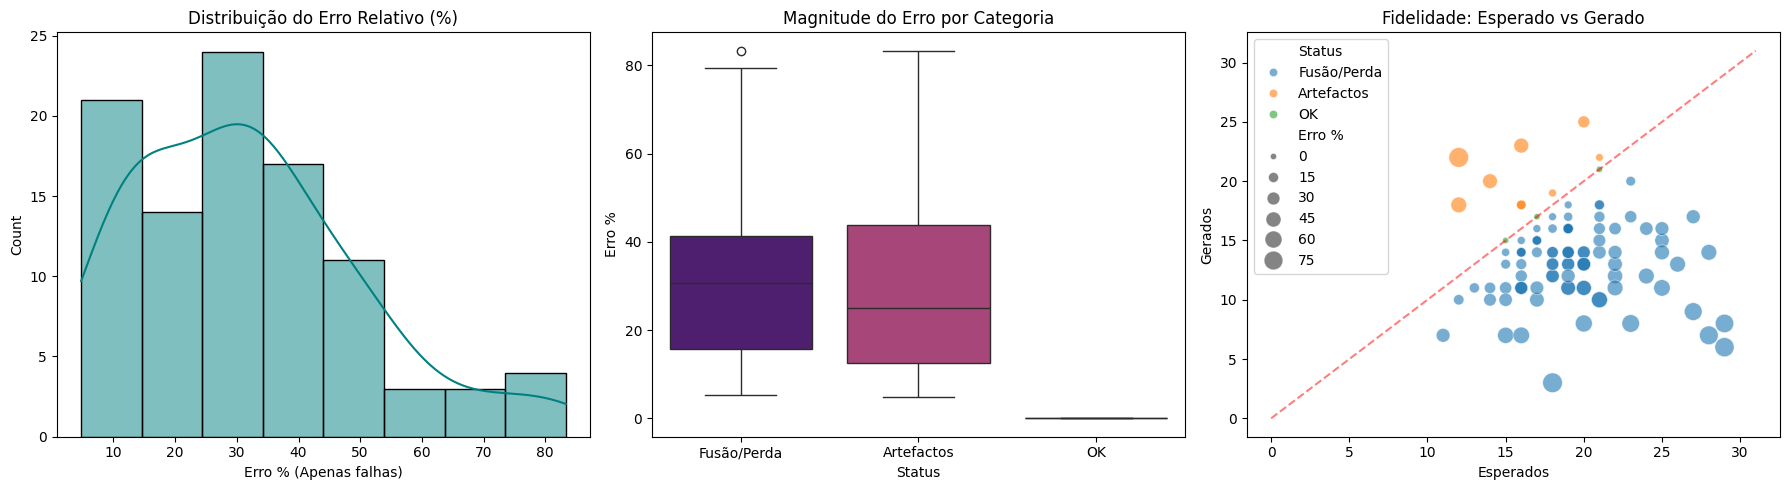


 Média de Erro Relativo: 30.77%

 Top 5 maiores erros:


,Ficheiro,Split,Esperados,Gerados,Erro %,Status
5,train_SNE_365900.jpg,train,12,22,83.33,Artefactos
74,train_SNE_352977.jpg,train,18,3,83.33,Fusão/Perda
67,train_SNE_389572.jpg,train,29,6,79.31,Fusão/Perda
97,train_SNE_385652.jpg,train,28,7,75.00,Fusão/Perda
22,train_SNE_446799.jpg,train,29,8,72.41,Fusão/Perda


In [10]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import measure
from tqdm import tqdm

BASE_SAMSUNG = "/content/drive/MyDrive/SAMSUNG"

BASE_PBC = os.path.join(BASE_SAMSUNG, "PBC-YOLO-811")
IMG_ROOT = os.path.join(BASE_PBC, "images")
LBL_ROOT = os.path.join(BASE_PBC, "labels")


OUT_IMG_SAM = os.path.join(BASE_SAMSUNG, "parametros/images")
OUT_MASK_SAM = os.path.join(BASE_SAMSUNG, "parametros/masks")


def validar_dataset_final(img_gen_root, mask_gen_root, lbl_orig_root, max_imgs=100):
    report_data = []

    if not os.path.exists(img_gen_root):
        print(f" Pasta não encontrada: {img_gen_root}")
        return pd.DataFrame()

    gerados_files = [f for f in os.listdir(img_gen_root) if f.lower().endswith(('.jpg', '.png'))]
    print(f" Encontrados {len(gerados_files)} ficheiros em 'parametros/images'.")

    for f in tqdm(gerados_files[:max_imgs]):
        parts = f.split('_', 1)
        if len(parts) < 2:
            continue

        split = parts[0]
        base_name = os.path.splitext(parts[1])[0]

        # 1. Contar Células Esperadas 
        txt_path = os.path.join(lbl_orig_root, split, base_name + ".txt")
        esperados = 0
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                esperados = len([line for line in file if line.strip()])
        else:
            # Fallback caso o nome do txt inclua o prefixo do split
            txt_path_alt = os.path.join(lbl_orig_root, split, os.path.splitext(f)[0] + ".txt")
            if os.path.exists(txt_path_alt):
                with open(txt_path_alt, 'r') as file:
                    esperados = len([line for line in file if line.strip()])

        # 2. Contar Células Geradas
        mask_name = os.path.splitext(f)[0] + ".png"
        mask_path = os.path.join(mask_gen_root, mask_name)

        gerados = 0
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is not None:

                gerados = measure.label(mask > 0).max()

        # 3. Cálculos
        diff = gerados - esperados
        erro_pct = (abs(diff) / esperados * 100) if esperados > 0 else (100 if gerados > 0 else 0)

        report_data.append({
            'Ficheiro': f,
            'Split': split,
            'Esperados': esperados,
            'Gerados': gerados,
            'Erro %': round(erro_pct, 2),
            'Status': "OK" if diff == 0 else ("Artefactos" if diff > 0 else "Fusão/Perda")
        })

    df = pd.DataFrame(report_data)

    # Visualização de Resultados
    if not df.empty:
        plt.figure(figsize=(18, 5))

        # Gráfico 1: Distribuição do Erro %
        plt.subplot(1, 3, 1)
        sns.histplot(df[df['Erro %'] > 0]['Erro %'], kde=True, color='teal')
        plt.title('Distribuição do Erro Relativo (%)')
        plt.xlabel('Erro % (Apenas falhas)')

        # Gráfico 2: Erro % por Status
        plt.subplot(1, 3, 2)
        sns.boxplot(data=df, x='Status', y='Erro %', palette='magma')
        plt.title('Magnitude do Erro por Categoria')

        # Gráfico 3: Real vs Gerado
        plt.subplot(1, 3, 3)
        sns.scatterplot(data=df, x='Esperados', y='Gerados', hue='Status', size='Erro %', sizes=(20, 200), alpha=0.6)

        max_val = max(df['Esperados'].max(), df['Gerados'].max()) + 2
        plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
        plt.title('Fidelidade: Esperado vs Gerado')

        plt.tight_layout()
        plt.show()

        print(f"\n Média de Erro Relativo: {df['Erro %'].mean():.2f}%")
        print("\n Top 5 maiores erros:")
        display(df.sort_values(by='Erro %', ascending=False).head(5))
    else:
        print(" Nenhum dado processado para gerar gráficos.")

    return df

# Executar
df_erro = validar_dataset_final(OUT_IMG_SAM, OUT_MASK_SAM, LBL_ROOT, max_imgs=100)

✅ Processadas 100 imagens.
📊 Média de Erro Relativo: 30.77%


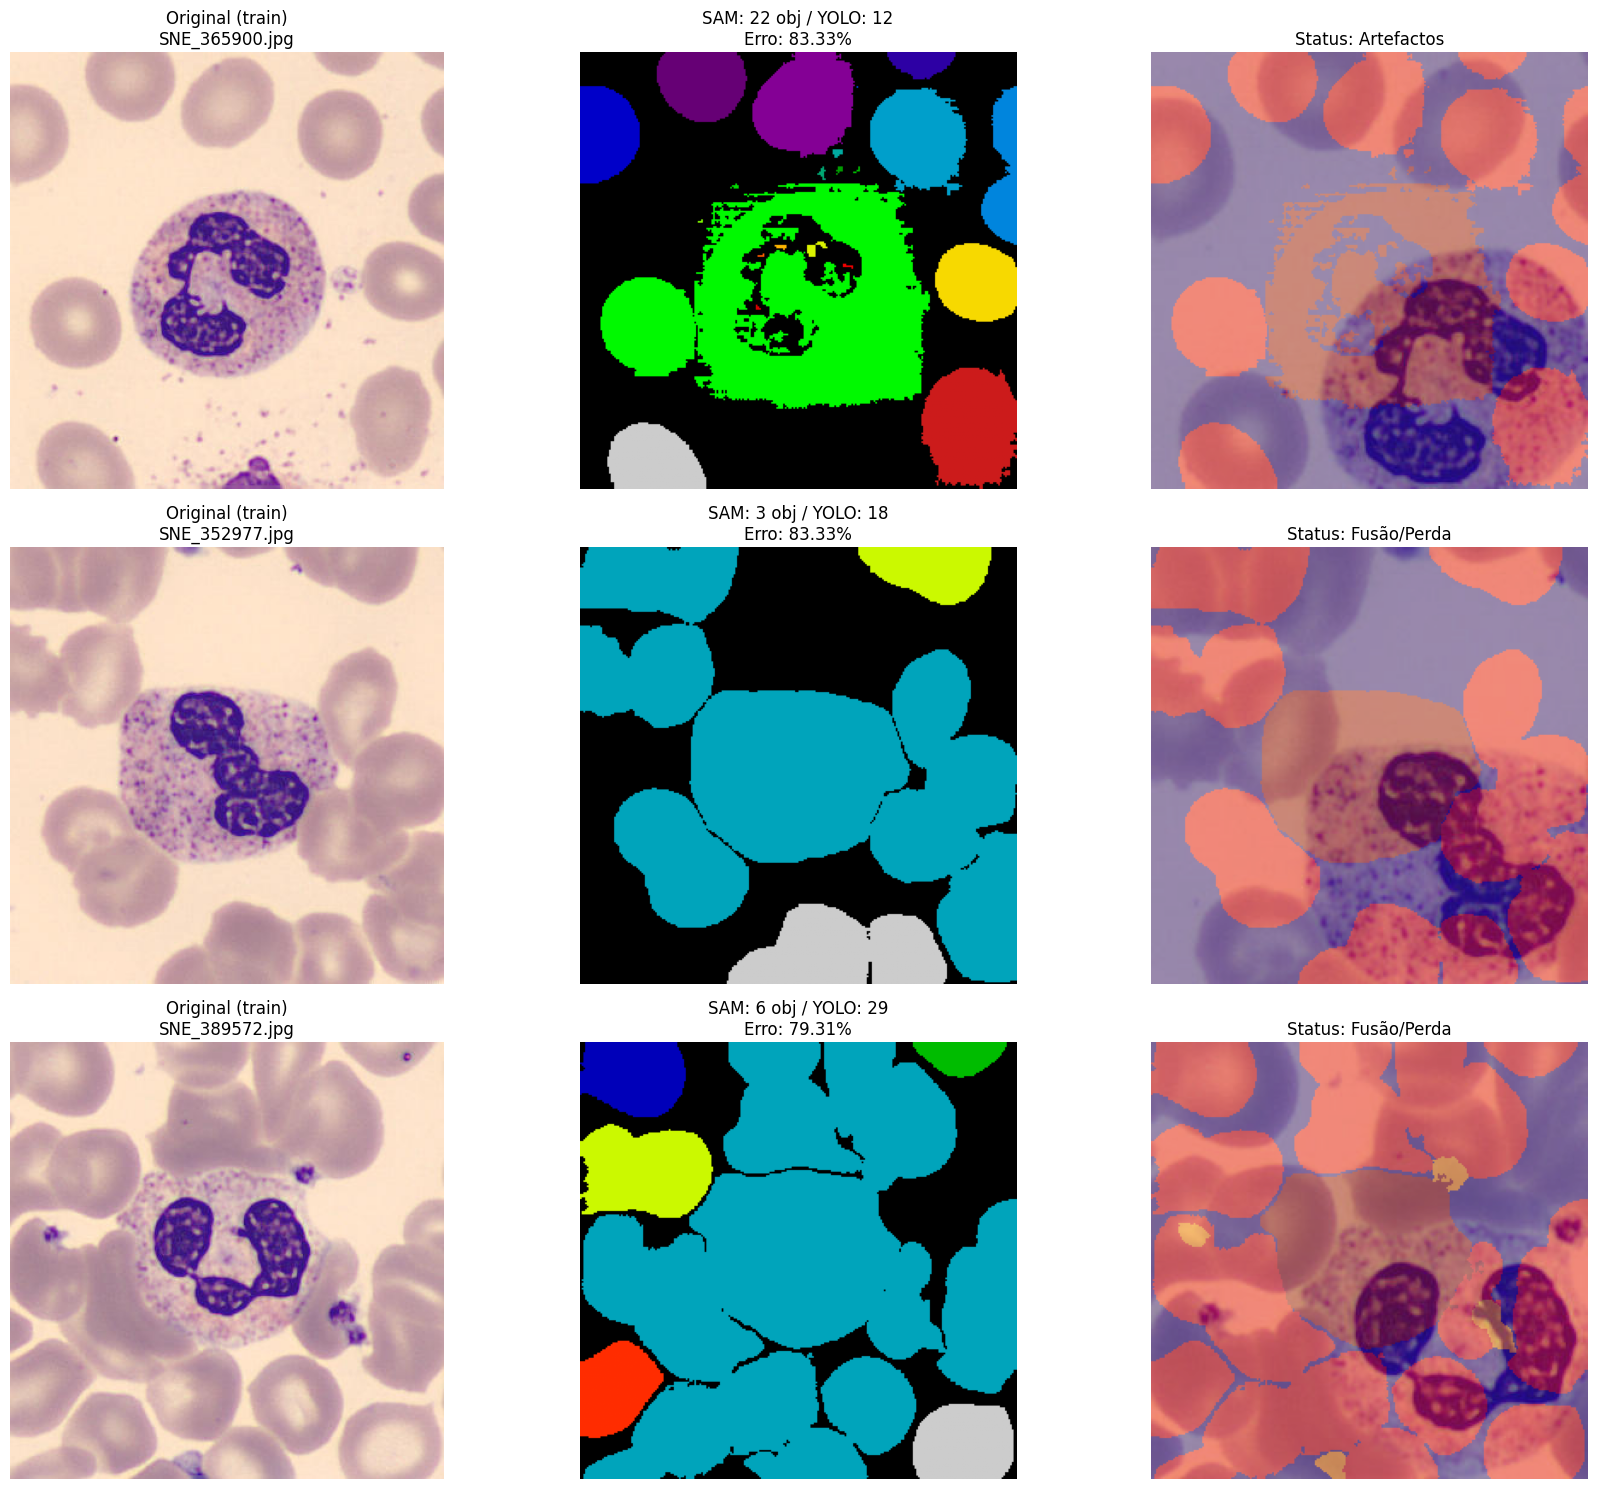

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import measure
from tqdm import tqdm


BASE_SAMSUNG = "/content/drive/MyDrive/SAMSUNG"

# Dataset Original
BASE_PBC = os.path.join(BASE_SAMSUNG, "PBC-YOLO-811/PBC-YOLO-811")
IMG_ROOT = os.path.join(BASE_PBC, "images")
LBL_ROOT = os.path.join(BASE_PBC, "labels")

# Resultados do SAM
OUT_BASE = os.path.join(BASE_SAMSUNG, "parametros")
OUT_IMG_SAM = os.path.join(OUT_BASE, "images")
OUT_MASK_SAM = os.path.join(OUT_BASE, "masks")


# 2. Função para validar

def validar_dataset_completo(img_root, lbl_root, mask_out_root, max_imgs=100):
    report_data = []
    total = 0

    for split in ['train', 'val', 'test']:
        if total >= max_imgs: break

        img_p = os.path.join(img_root, split)
        lbl_p = os.path.join(lbl_root, split)

        if not os.path.exists(img_p): continue

        files = [f for f in os.listdir(img_p) if f.lower().endswith(('.jpg', '.png'))]

        for f in files:
            if total >= max_imgs: break

            # 1. Contagem YOLO
            txt_path = os.path.join(lbl_p, os.path.splitext(f)[0] + ".txt")
            esperados = 0
            if os.path.exists(txt_path):
                with open(txt_path, 'r') as file:
                    esperados = len([l for l in file if l.strip()])

            # 2. Contagem SAM
            mask_name = f"{split}_{os.path.splitext(f)[0]}.png"
            m_path = os.path.join(mask_out_root, mask_name)

            gerados = 0
            if os.path.exists(m_path):
                mask = cv2.imread(m_path, cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    gerados = measure.label(mask > 0).max()

            diff = gerados - esperados
            erro_pct = (abs(diff) / esperados * 100) if esperados > 0 else (100 if gerados > 0 else 0)

            report_data.append({
                'Ficheiro': f,
                'Split': split,
                'Esperados': esperados,
                'Gerados': gerados,
                'Erro %': round(erro_pct, 2),
                'Status': "OK" if diff == 0 else ("Artefactos" if diff > 0 else "Fusão/Perda")
            })
            total += 1

    return pd.DataFrame(report_data)

# 3. VISUALIZAÇÃO DOS ERROS CRÍTICOS

def visualizar_erros_criticos(df, img_root, mask_root):
    if df.empty:
        print(" O DataFrame está vazio. Verifique os caminhos.")
        return

    piores = df.sort_values(by='Erro %', ascending=False).head(3)
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    for i, (idx, row) in enumerate(piores.iterrows()):
        split = row['Split']
        f = row['Ficheiro']

        # Caminhos para carregar as imagens do erro
        img_path = os.path.join(img_root, split, f)
        mask_path = os.path.join(mask_root, f"{split}_{os.path.splitext(f)[0]}.png")

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is not None and mask is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            labeled_mask = measure.label(mask > 0)

            # Coluna 0: Original
            axes[i, 0].imshow(img_rgb)
            axes[i, 0].set_title(f"Original ({split})\n{f}")

            # Coluna 1: Máscara Labeled
            axes[i, 1].imshow(labeled_mask, cmap='nipy_spectral')
            axes[i, 1].set_title(f"SAM: {row['Gerados']} obj / YOLO: {row['Esperados']}\nErro: {row['Erro %']}%")

            # Coluna 2: Overlay
            axes[i, 2].imshow(img_rgb)
            axes[i, 2].imshow(mask, alpha=0.4, cmap='jet')
            axes[i, 2].set_title(f"Status: {row['Status']}")

        for ax in axes[i]: ax.axis('off')

    plt.tight_layout()
    plt.show()

# 4. EXECUÇÃO

df_final = validar_dataset_completo(IMG_ROOT, LBL_ROOT, OUT_MASK_SAM, max_imgs=100)

if not df_final.empty:
    print(f" Processadas {len(df_final)} imagens.")
    print(f" Média de Erro Relativo: {df_final['Erro %'].mean():.2f}%")
    visualizar_erros_criticos(df_final, IMG_ROOT, OUT_MASK_SAM)